In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [179]:
class music_grid(object):

  def __init__( self, fname, fieldname='rho' ):
    with h5py.File(fname) as hf:
      self.levelmin = hf['/header'].attrs['levelmin']
      self.levelmax = hf['/header'].attrs['levelmax']
      self.len = np.zeros((1+self.levelmax-self.levelmin,3), dtype=int)
      self.len[:,0] = np.array( hf['/header/grid_len_x'])
      self.len[:,1] = np.array( hf['/header/grid_len_y'])
      self.len[:,2] = np.array( hf['/header/grid_len_z'])
      self.off = np.zeros((1+self.levelmax-self.levelmin,3), dtype=int)
      self.off[:,0] = np.array( hf['/header/grid_off_x'] )
      self.off[:,1] = np.array( hf['/header/grid_off_y'] )
      self.off[:,2] = np.array( hf['/header/grid_off_z'] )

      self.absoff = np.zeros_like(self.off)
      for i in range(self.off.shape[0] ):
        self.absoff[i,:] = self.off[i,:] * 2**(1+self.levelmax-self.levelmin-i)
      self.absoff = np.cumsum(self.absoff,axis=0)

      self.density = {}
      for i in range(self.levelmin, self.levelmax+1):
        self.density[i] = np.array( hf[f'level_{i:03d}_DM_'+fieldname])[4:-4,4:-4,4:-4]
      
    
  def get_slice( self, islz ):
    scale = 2**(self.levelmax-self.levelmin)
    iislz = islz//scale
    img = self.density[self.levelmin][...,iislz].repeat( scale, axis=0 ).repeat( scale, axis=1 )# *0

    for i,ilvl in enumerate(range(self.levelmin+1, self.levelmax+1)):
      scale  = 2**(self.levelmax-ilvl)
      if (islz >= self.absoff[i+1,2]) & (islz <  self.absoff[i+1,2]+scale*self.len[i+1,2]):
        iislz = (islz - self.absoff[i+1,2])//scale
        imgt = self.density[ilvl][...,iislz].repeat( scale, axis=0 ).repeat( scale, axis=1 )# *0+i+1
        il = self.absoff[i+1,0]
        ir = self.absoff[i+1,0]+scale*self.len[i+1,0]
        jl = self.absoff[i+1,1]
        jr = self.absoff[i+1,1]+scale*self.len[i+1,1]
        
        img[il:ir,jl:jr] = imgt

    return img

In [184]:
field = 'vz'

mg1 = music_grid('debug.hdf5',field)
img1 = mg1.get_slice( 256 )

mg2 = music_grid('debug_master.hdf5',field)
img2 = mg2.get_slice( 256 )

Text(0.5, 1.0, 'difference')

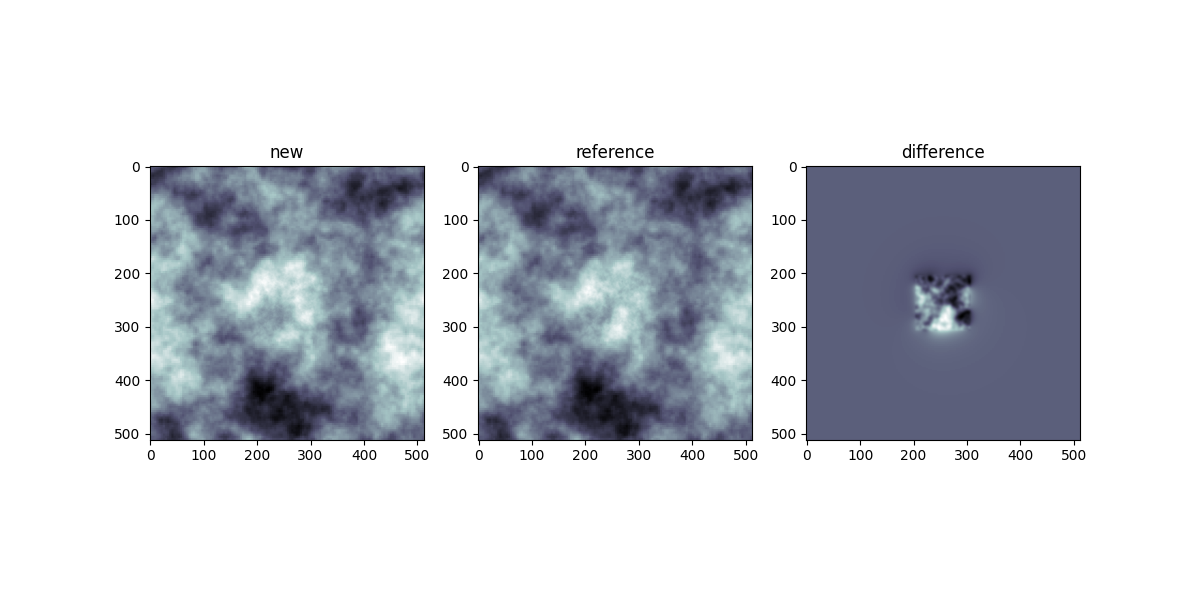

In [185]:
fig,ax  = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow( img1, cmap='bone')
ax[0].set_title('new')
ax[1].imshow( img2, cmap='bone')
ax[1].set_title('reference')
ax[2].imshow( img2-img1, cmap='bone')
ax[2].set_title('difference')
